In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import time
from sklearn import metrics
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
"""
train_data_path = "train_data/"
total_data = []

for file_name in glob.glob(train_data_path+"x*_plus_bi.csv"):
  print(file_name)
  with open(file_name, "r") as file:
    data = np.loadtxt(file, delimiter=",")
  #print(data.shape)
  data = data.reshape([495, 100, -1])
  total_data.append(data)
  

total_data = np.array(total_data)
print(total_data.shape)

with open(train_data_path +"images_data.npy", "wb") as f:
    np.save(f, total_data)
"""

with open("./norm_images_data_dim_16.npy", "rb") as f:
  total_data = np.load(f)
print(total_data.shape)

(576, 495, 100, 16)


In [4]:
np.random.seed(7777)

rand_idx = np.arange(total_data.shape[0])

np.random.shuffle(rand_idx)

cut = total_data.shape[0]//8

test_data = total_data[rand_idx[:cut]]
train_data = total_data[rand_idx[cut:]]

print(test_data.shape)
print(train_data.shape)

train_X = train_data[:, :, :, :-1]
train_Y = train_data[:, :, :, -1:]
test_X = test_data[:, :, :, :-1]
test_Y = test_data[:, :, :, -1:]


A = np.arange(49500, dtype=np.int32).reshape(495, 100)

print(A)
A_up = A + 1
A_down = A - 1
A_left = A - 100
A_right = A + 100

A_idx = np.stack([A_left, A_down, A_up, A_right, A], axis=-1)

A_idx[0, :, 0] = -1
A_idx[:, 0, 1] = -1
A_idx[:, -1, 2] = -1
A_idx[-1, :, 3] = -1

A_idx = A_idx.reshape([49500, -1, 1])
print(A_idx)

print("A_idx:", A_idx.shape)

is_there_no_minus_one = (A_idx != -1)[:, :, 0]

D = np.sqrt(1/np.sum(is_there_no_minus_one, axis=-1)).astype(np.float32)

source_A = np.arange(49500).reshape(49500, 1, 1)

source_D = tf.gather_nd(D, source_A)
dest_D = tf.gather_nd(D, A_idx)

new_D = (source_D * dest_D).numpy()
print(new_D)

"""
source_A = np.tile(np.arange(49500).reshape(49500, 1, 1), [1, 5, 1])
sparse_A_idx = np.concatenate([source_A, A_idx], axis=-1)

print("sparse_A_idx:", sparse_A_idx.shape)
print(sparse_A_idx)
is_there_no_minus_one = np.all(sparse_A_idx!=-1, axis=-1)

new_sparse_A_idx = sparse_A_idx[is_there_no_minus_one]

#print(is_there_no_minus_one.shape)

D = np.sqrt(1/np.sum(is_there_no_minus_one, axis=-1)).astype(np.float32)

#D = tf.sparse.SparseTensor(indices = np.stack([np.arange(49500)]*2, axis=-1),
#                          values = D,
#                          dense_shape=[49500, 49500])

print(D)

print("new_sparse_A_idx:", new_sparse_A_idx.shape)
#print(new_sparse_A_idx)

sparse_A_values = D[new_sparse_A_idx[:, 0]] * D[new_sparse_A_idx[:, 1]]

print("sAv:", sparse_A_values.shape)
#print(sparse_A_values)

sparse_A = tf.sparse.SparseTensor(indices = new_sparse_A_idx,
                                 values = sparse_A_values,
                                 dense_shape=[49500, 49500])

print(sparse_A)

#print(tf.sparse.sparse_dense_matmul(D, A))

"""
total_epochs = 200
batch_size = 12
units = 196
n_layers = 12
step_per_epoch = (train_X.shape[0]+batch_size-1)//batch_size

(72, 495, 100, 16)
(504, 495, 100, 16)
[[    0     1     2 ...    97    98    99]
 [  100   101   102 ...   197   198   199]
 [  200   201   202 ...   297   298   299]
 ...
 [49200 49201 49202 ... 49297 49298 49299]
 [49300 49301 49302 ... 49397 49398 49399]
 [49400 49401 49402 ... 49497 49498 49499]]
[[[   -1]
  [   -1]
  [    1]
  [  100]
  [    0]]

 [[   -1]
  [    0]
  [    2]
  [  101]
  [    1]]

 [[   -1]
  [    1]
  [    3]
  [  102]
  [    2]]

 ...

 [[49397]
  [49496]
  [49498]
  [   -1]
  [49497]]

 [[49398]
  [49497]
  [49499]
  [   -1]
  [49498]]

 [[49399]
  [49498]
  [   -1]
  [   -1]
  [49499]]]
A_idx: (49500, 5, 1)
[[0.         0.         0.28867513 0.28867513 0.3333333 ]
 [0.         0.28867513 0.25       0.2236068  0.25      ]
 [0.         0.25       0.25       0.2236068  0.25      ]
 ...
 [0.2236068  0.25       0.25       0.         0.25      ]
 [0.2236068  0.25       0.28867513 0.         0.25      ]
 [0.28867513 0.28867513 0.         0.         0.3333333 ]]


2023-02-10 20:48:12.722619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 20:48:13.093233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c2:00.0, compute capability: 8.6


In [5]:
test_A = tf.expand_dims(A_idx, axis=0)
test_D = tf.expand_dims(D, axis=0)
from_idx = tf.expand_dims(tf.expand_dims(tf.expand_dims(np.arange(49500), axis=-1), axis=-1), axis=0)

print(test_A)
print(test_D)
print(from_idx)

#print(tf.gather_nd(tf.reshape(train_X[:1], [1, -1, train_X.shape[-1]]), test_A, batch_dims=1))

to_D = tf.gather_nd(test_D, test_A, batch_dims=1)
from_D = tf.gather_nd(test_D, from_idx, batch_dims=1)

print(to_D * from_D)

tf.Tensor(
[[[[   -1]
   [   -1]
   [    1]
   [  100]
   [    0]]

  [[   -1]
   [    0]
   [    2]
   [  101]
   [    1]]

  [[   -1]
   [    1]
   [    3]
   [  102]
   [    2]]

  ...

  [[49397]
   [49496]
   [49498]
   [   -1]
   [49497]]

  [[49398]
   [49497]
   [49499]
   [   -1]
   [49498]]

  [[49399]
   [49498]
   [   -1]
   [   -1]
   [49499]]]], shape=(1, 49500, 5, 1), dtype=int32)
tf.Tensor([[0.57735026 0.5        0.5        ... 0.5        0.5        0.57735026]], shape=(1, 49500), dtype=float32)
tf.Tensor(
[[[[    0]]

  [[    1]]

  [[    2]]

  ...

  [[49497]]

  [[49498]]

  [[49499]]]], shape=(1, 49500, 1, 1), dtype=int64)
tf.Tensor(
[[[0.         0.         0.28867513 0.28867513 0.3333333 ]
  [0.         0.28867513 0.25       0.2236068  0.25      ]
  [0.         0.25       0.25       0.2236068  0.25      ]
  ...
  [0.2236068  0.25       0.25       0.         0.25      ]
  [0.2236068  0.25       0.28867513 0.         0.25      ]
  [0.28867513 0.28867513 0.         

In [6]:



"""
assert False

for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_X[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])

  reds = test_Y[idx].flatten() > 0
  print(test_Y.shape )
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  plt.show()
"""

'\nassert False\n\nfor idx in range(test_X.shape[0]):\n\n  fig = plt.figure(num=0, clear=True, figsize=[50, 10])\n  ax = plt.subplot(1, 1, 1)\n\n  cells = test_X[idx]\n  print(cells.shape)\n  cells = cells.reshape([-1, cells.shape[-1]])\n  colors = np.zeros([cells.shape[0], 3])\n\n  reds = test_Y[idx].flatten() > 0\n  print(test_Y.shape )\n  colors[reds] = [1.0, 0.0, 0.0]\n  \n  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)\n  \n    \n  \n  plt.tight_layout()\n  plt.xlim([0.0, 5.0])\n  plt.ylim([0.0, 1.0])\n  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")\n  plt.show()\n'

In [7]:
class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None

In [8]:
train_batcher = Batcher(train_X, train_Y, randomize=True)
test_batcher = Batcher(test_X, test_Y, randomize=False )

In [9]:
class GraphConv(tf.keras.layers.Layer):
  #hard_coded_A :(1, 49500, 5, 1)  
  hard_coded_A = np.expand_dims(A_idx, axis=0)
  #hard_coded_D :(1, 49500, 5, 1)
  hard_coded_D = np.expand_dims(np.expand_dims(new_D, axis=0), axis=-1)
  def __init__(self, unit):
    super(GraphConv, self).__init__()

    self.unit = unit
    
    self.d1 = tf.keras.layers.Dense(self.unit)
    self.b1 = tf.keras.layers.BatchNormalization()
    
  def call(self, x, training=False):
    # x = (bsz, 49500, n_feature)
    A_idx = tf.tile(self.hard_coded_A, [x.shape[0],1,1,1])
    # A_idx = (bsz, 49500, 5, 1)
    # mask = (bsz, 49500, 4, 1): bool
    
    #features = (bsz, 49500, 5, n_feature)
    features = tf.gather_nd(x, A_idx, batch_dims=1)
    
    #y1 = (bsz, 49500, 5, unit)
    y1 = self.d1(features)
    y1 = y1 * self.hard_coded_D
    #y1 = (bsz, 49500, unit)
    y1 = tf.reduce_sum(y1, axis=2)
    y1 = tf.nn.relu(y1)
    y1 = self.b1(y1, training=training)
    
    return y1
  

class My_GNN(tf.keras.Model):
  def __init__(self, unit=16, n_layers=12):
    super(My_GNN, self).__init__()
    
    self.unit = unit
    self.n_layers = n_layers
    
    #self.b1 = tf.keras.layers.BatchNormalization()
    
    self.gnn_layers = []
    for _ in range(self.n_layers):
        self.gnn_layers.append(GraphConv(self.unit))
    
    self.f = tf.keras.layers.Dense(1)

  def call(self, x, training = False):
    # x = (bsz, 49500, n_feature) : float32
    y = x
    for ly in self.gnn_layers:
      y = ly(y, training=training)
    y = self.f(y)
    return y




In [10]:

learning_rate = 0.0001

model = My_GNN(units, n_layers = n_layers)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                reduction="none")
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

checkpoint_dir = "./ckpt/gcn_"+f"u={units}_l={n_layers}"
checkpoint_prefix = os.path.join(checkpoint_dir, "tf")
checkpoint = tf.train.Checkpoint(model=model,
                                 optimizer = optimizer
                                )
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))





@tf.function
def training_step(inp, targ):
  with tf.GradientTape() as tape:
    pred = model(inp, training = True)
    #print(pred[0])
    loss = tf.reduce_mean(loss_object(targ, pred))
  variables = model.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  
  return loss

def validation():
  test_step = test_X.shape[0] // batch_size
  test_batcher.reset_random()
  total_loss = 0
  total_pred = []
  total_targ = []
  for i_step in range(test_step):
    inp, targ = test_batcher.get_batch(batch_size)
    inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
    pred = model(inp, training = False)
    pred = tf.reshape(pred, targ.shape)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
  if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
    inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
    inp = np.reshape(inp, (inp.shape[0], 49500, -1))
    pred = model(inp, training = False)
    pred = tf.reshape(pred, targ.shape)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
    
  total_loss /= test_X.shape[0]
  
  total_pred = np.concatenate(total_pred, axis=0)
  total_targ = np.concatenate(total_targ, axis=0)
  
  total_pred_flat = total_pred.flatten()
  total_targ_flat = total_targ.flatten()
  
  fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  
  return total_loss, auc

2023-02-10 20:48:16.282198: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 0 Step 10 Loss: 0.8893
Epoch 0 Step 20 Loss: 0.8541
Epoch 0 Step 30 Loss: 0.8346
Epoch 0 Step 40 Loss: 0.8238
Time taken for 1 epoch 82.7895815372467 sec
Epoch 0 Loss: 0.8496
Validation Loss: 0.6961
Epoch 1 Step 10 Loss: 0.7832
Epoch 1 Step 20 Loss: 0.7753
Epoch 1 Step 30 Loss: 0.7637
Epoch 1 Step 40 Loss: 0.7590
Time taken for 1 epoch 77.88298487663269 sec
Epoch 1 Loss: 0.7791
Validation Loss: 0.6657
Epoch 2 Step 10 Loss: 0.7508
Epoch 2 Step 20 Loss: 0.7188
Epoch 2 Step 30 Loss: 0.7198
Epoch 2 Step 40 Loss: 0.7111
Time taken for 1 epoch 77.93715119361877 sec
Epoch 2 Loss: 0.7255
Validation Loss: 0.6225
Epoch 3 Step 10 Loss: 0.6909
Epoch 3 Step 20 Loss: 0.6863
Epoch 3 Step 30 Loss: 0.6868
Epoch 3 Step 40 Loss: 0.6482
Time taken for 1 epoch 77.9105875492096 sec
Epoch 3 Loss: 0.6851
Validation Loss: 0.5656
Epoch 4 Step 10 Loss: 0.6655
Epoch 4 Step 20 Loss: 0.6523
Epoch 4 Step 30 Loss: 0.6544
Epoch 4 Step 40 Loss: 0.6352
Time taken for 1 epoch 77.9139552116394 sec
Epoch 4 Loss: 0.65

Epoch 39 Step 20 Loss: 0.2524
Epoch 39 Step 30 Loss: 0.2559
Epoch 39 Step 40 Loss: 0.2527
Time taken for 1 epoch 77.87252163887024 sec
Epoch 39 Loss: 0.2516
Validation Loss: 0.2454
Epoch 40 Step 10 Loss: 0.2488
Epoch 40 Step 20 Loss: 0.2424
Epoch 40 Step 30 Loss: 0.2426
Epoch 40 Step 40 Loss: 0.2434
Time taken for 1 epoch 77.84117937088013 sec
Epoch 40 Loss: 0.2478
Validation Loss: 0.2404
Epoch 41 Step 10 Loss: 0.2393
Epoch 41 Step 20 Loss: 0.2495
Epoch 41 Step 30 Loss: 0.2368
Epoch 41 Step 40 Loss: 0.2405
Time taken for 1 epoch 77.82412314414978 sec
Epoch 41 Loss: 0.2436
Validation Loss: 0.2364
Epoch 42 Step 10 Loss: 0.2369
Epoch 42 Step 20 Loss: 0.2345
Epoch 42 Step 30 Loss: 0.2375
Epoch 42 Step 40 Loss: 0.2420
Time taken for 1 epoch 77.8706636428833 sec
Epoch 42 Loss: 0.2395
Validation Loss: 0.2323
Epoch 43 Step 10 Loss: 0.2355
Epoch 43 Step 20 Loss: 0.2340
Epoch 43 Step 30 Loss: 0.2321
Epoch 43 Step 40 Loss: 0.2320
Time taken for 1 epoch 77.84406447410583 sec
Epoch 43 Loss: 0.2355


Epoch 78 Step 20 Loss: 0.1445
Epoch 78 Step 30 Loss: 0.1467
Epoch 78 Step 40 Loss: 0.1408
Time taken for 1 epoch 77.84492564201355 sec
Epoch 78 Loss: 0.1484
Validation Loss: 0.1452
Epoch 79 Step 10 Loss: 0.1516
Epoch 79 Step 20 Loss: 0.1451
Epoch 79 Step 30 Loss: 0.1416
Epoch 79 Step 40 Loss: 0.1510
Time taken for 1 epoch 77.86036157608032 sec
Epoch 79 Loss: 0.1471
Validation Loss: 0.1435
Epoch 80 Step 10 Loss: 0.1360
Epoch 80 Step 20 Loss: 0.1478
Epoch 80 Step 30 Loss: 0.1603
Epoch 80 Step 40 Loss: 0.1363
Time taken for 1 epoch 77.8454704284668 sec
Epoch 80 Loss: 0.1450
Validation Loss: 0.1423
Epoch 81 Step 10 Loss: 0.1393
Epoch 81 Step 20 Loss: 0.1449
Epoch 81 Step 30 Loss: 0.1403
Epoch 81 Step 40 Loss: 0.1325
Time taken for 1 epoch 77.84031343460083 sec
Epoch 81 Loss: 0.1438
Validation Loss: 0.1407
Epoch 82 Step 10 Loss: 0.1379
Epoch 82 Step 20 Loss: 0.1388
Epoch 82 Step 30 Loss: 0.1390
Epoch 82 Step 40 Loss: 0.1409
Time taken for 1 epoch 77.8454053401947 sec
Epoch 82 Loss: 0.1428
V

Epoch 116 Loss: 0.1102
Validation Loss: 0.1090
Epoch 117 Step 10 Loss: 0.1012
Epoch 117 Step 20 Loss: 0.1157
Epoch 117 Step 30 Loss: 0.1070
Epoch 117 Step 40 Loss: 0.1021
Time taken for 1 epoch 77.85420870780945 sec
Epoch 117 Loss: 0.1087
Validation Loss: 0.1083
Epoch 118 Step 10 Loss: 0.1047
Epoch 118 Step 20 Loss: 0.1192
Epoch 118 Step 30 Loss: 0.1112
Epoch 118 Step 40 Loss: 0.1042
Time taken for 1 epoch 77.8541624546051 sec
Epoch 118 Loss: 0.1090
Validation Loss: 0.1078
Epoch 119 Step 10 Loss: 0.1146
Epoch 119 Step 20 Loss: 0.1048
Epoch 119 Step 30 Loss: 0.1136
Epoch 119 Step 40 Loss: 0.1079
Time taken for 1 epoch 77.86730766296387 sec
Epoch 119 Loss: 0.1084
Validation Loss: 0.1072
Epoch 120 Step 10 Loss: 0.1056
Epoch 120 Step 20 Loss: 0.1141
Epoch 120 Step 30 Loss: 0.1018
Epoch 120 Step 40 Loss: 0.1072
Time taken for 1 epoch 77.85016655921936 sec
Epoch 120 Loss: 0.1069
Validation Loss: 0.1066
Epoch 121 Step 10 Loss: 0.1014
Epoch 121 Step 20 Loss: 0.1055
Epoch 121 Step 30 Loss: 0.10

Epoch 154 Loss: 0.0913
Validation Loss: 0.0915
Epoch 155 Step 10 Loss: 0.0883
Epoch 155 Step 20 Loss: 0.0944
Epoch 155 Step 30 Loss: 0.0967
Epoch 155 Step 40 Loss: 0.0886
Time taken for 1 epoch 77.83270025253296 sec
Epoch 155 Loss: 0.0913
Validation Loss: 0.0913
Epoch 156 Step 10 Loss: 0.0806
Epoch 156 Step 20 Loss: 0.0880
Epoch 156 Step 30 Loss: 0.0901
Epoch 156 Step 40 Loss: 0.0910
Time taken for 1 epoch 77.85267853736877 sec
Epoch 156 Loss: 0.0906
Validation Loss: 0.0909
Epoch 157 Step 10 Loss: 0.0834
Epoch 157 Step 20 Loss: 0.0863
Epoch 157 Step 30 Loss: 0.1072
Epoch 157 Step 40 Loss: 0.0905
Time taken for 1 epoch 77.86218881607056 sec
Epoch 157 Loss: 0.0896
Validation Loss: 0.0905
Epoch 158 Step 10 Loss: 0.0908
Epoch 158 Step 20 Loss: 0.0861
Epoch 158 Step 30 Loss: 0.0931
Epoch 158 Step 40 Loss: 0.0874
Time taken for 1 epoch 77.8393292427063 sec
Epoch 158 Loss: 0.0901
Validation Loss: 0.0901
Epoch 159 Step 10 Loss: 0.1017
Epoch 159 Step 20 Loss: 0.1059
Epoch 159 Step 30 Loss: 0.08

Epoch 192 Loss: 0.0807
Validation Loss: 0.0815
Epoch 193 Step 10 Loss: 0.0827
Epoch 193 Step 20 Loss: 0.0750
Epoch 193 Step 30 Loss: 0.0741
Epoch 193 Step 40 Loss: 0.0706
Time taken for 1 epoch 77.89240622520447 sec
Epoch 193 Loss: 0.0802
Validation Loss: 0.0812
Epoch 194 Step 10 Loss: 0.0839
Epoch 194 Step 20 Loss: 0.0755
Epoch 194 Step 30 Loss: 0.0742
Epoch 194 Step 40 Loss: 0.0765
Time taken for 1 epoch 77.89485216140747 sec
Epoch 194 Loss: 0.0804
Validation Loss: 0.0810
Epoch 195 Step 10 Loss: 0.0807
Epoch 195 Step 20 Loss: 0.0704
Epoch 195 Step 30 Loss: 0.0762
Epoch 195 Step 40 Loss: 0.0823
Time taken for 1 epoch 77.88367676734924 sec
Epoch 195 Loss: 0.0798
Validation Loss: 0.0809
Epoch 196 Step 10 Loss: 0.0998
Epoch 196 Step 20 Loss: 0.0737
Epoch 196 Step 30 Loss: 0.0815
Epoch 196 Step 40 Loss: 0.0807
Time taken for 1 epoch 77.90291666984558 sec
Epoch 196 Loss: 0.0798
Validation Loss: 0.0806
Epoch 197 Step 10 Loss: 0.0767
Epoch 197 Step 20 Loss: 0.0762
Epoch 197 Step 30 Loss: 0.0

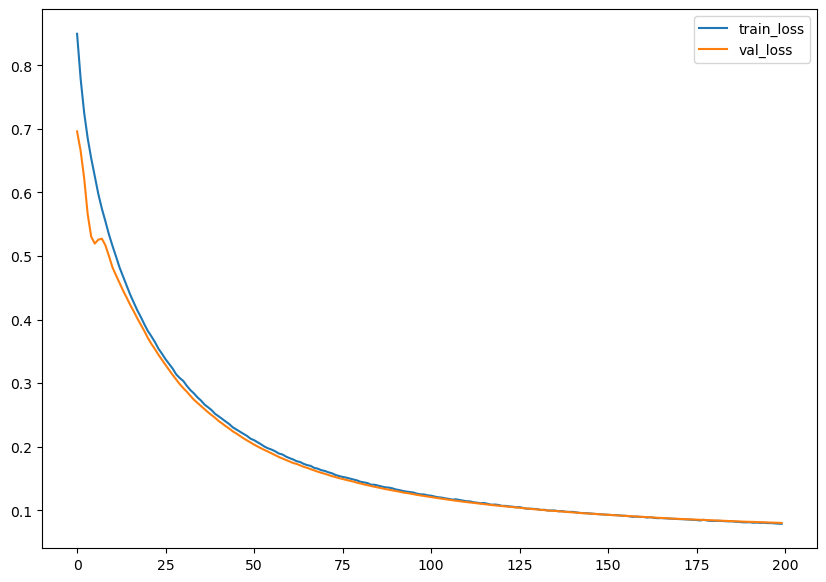

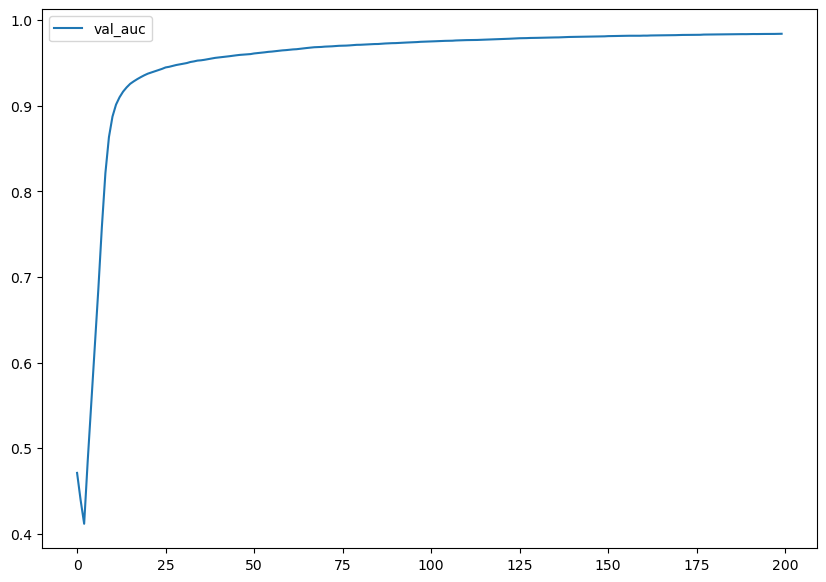

In [11]:
train_losses = []
val_losses = []

val_aucs = []

for ep in range(total_epochs):
  train_batcher.reset_random()
  total_loss = 0
  start = time.time()
  for i_step in range(step_per_epoch):
    inp, targ = train_batcher.get_batch(batch_size)
    inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
    targ = tf.reshape(targ, (targ.shape[0], 49500, -1))
    loss = training_step(inp, targ)
    
    total_loss += loss

    if (i_step+1) % 10 == 0:
      print(f"Epoch {ep} Step {i_step+1} Loss: {loss.numpy():.4f}")
  total_loss /= step_per_epoch
  print(f"Time taken for 1 epoch {time.time()-start} sec")
  print(f"Epoch {ep} Loss: {total_loss.numpy():.4f}")
  train_losses.append(total_loss)
  
  val_loss, val_auc = validation()
  
  print(f"Validation Loss: {val_loss:.4f}")
  
  checkpoint.save(file_prefix=checkpoint_prefix)
  
  val_losses.append(val_loss)
  val_aucs.append(val_auc)
  
import matplotlib.pyplot as plt

plt.figure(figsize = [10, 7])
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.show()

plt.figure(figsize = [10, 7])
plt.plot(val_aucs, label="val_auc")
plt.legend()
plt.show()

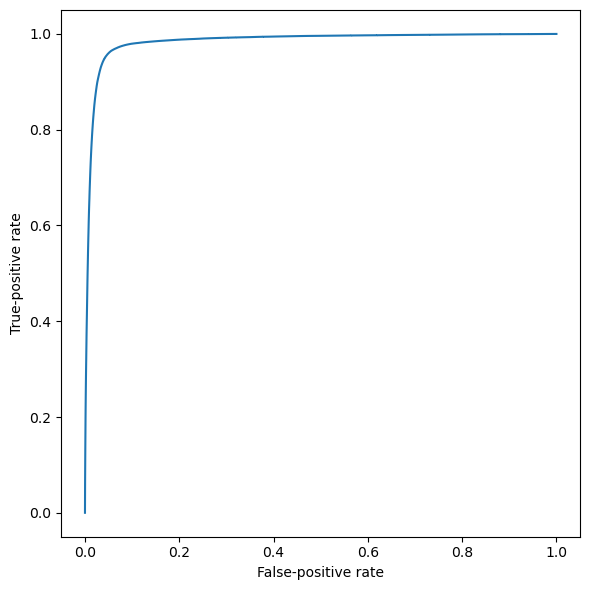

In [12]:

test_step = test_X.shape[0] // batch_size
test_batcher.reset_random()
total_loss = 0
total_test_inp = []
total_pred = []
total_targ = []
for i_step in range(test_step):
  inp, targ = test_batcher.get_batch(batch_size)
  inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
  pred = model(inp, training = False)
  pred = tf.reshape(pred, targ.shape)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)
if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
  inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
  inp = tf.reshape(inp, (inp.shape[0], 49500, -1))
  pred = model(inp, training = False)
  pred = tf.reshape(pred, targ.shape)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)

total_loss /= test_X.shape[0]

total_pred = np.concatenate(total_pred, axis=0)
total_targ = np.concatenate(total_targ, axis=0)

total_pred_flat = total_pred.flatten()
total_targ_flat = total_targ.flatten()

fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel("False-positive rate")
plt.ylabel("True-positive rate")
plt.tight_layout()

plt.show()

(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)
(495, 100, 1)
(495, 100, 22)

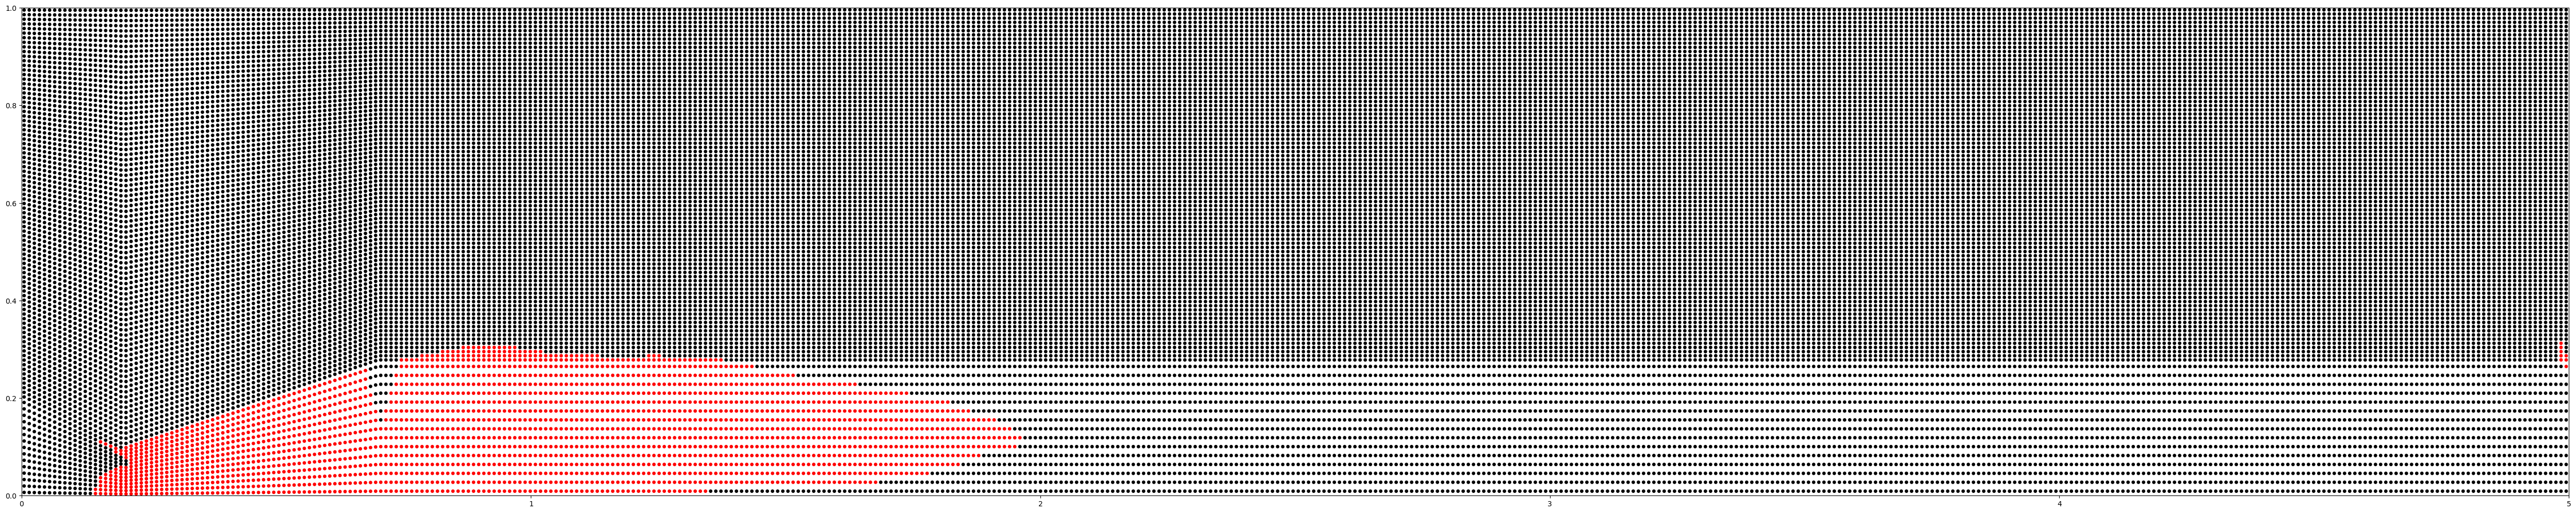

In [13]:

hits = 0
trials = 0


with open("./images_data.npy", "rb") as f:
  xys = np.load(f)
  test_xys = xys[rand_idx[:cut]]

fig_path = f"./gcn_"+f"u={units}_l={n_layers}_result/"

if not os.path.exists(fig_path):
    os.mkdir(fig_path)




for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_xys[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])
  total_pred_flat = total_pred[idx].flatten()
  sorted_pred = np.sort(total_pred_flat)
  thres = sorted_pred[-np.size(total_pred_flat)//20]
  reds = total_pred_flat > thres
  
  #reds = total_targ[idx].flatten() > 0
  #reds = test_Y[idx].flatten() > 0
  print(total_targ[idx].shape)
  
  trials += np.size(total_targ[idx])
  hits += np.sum(total_targ[idx].flatten() == reds)
  
  
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  plt.savefig(fig_path+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  #plt.show()
  #assert False
  
print("acc:", hits / trials)

In [ ]:
#new) norm data

#u=128 l=12 acc: 0.9721986531
#u=96 l=16 bsz=16 acc:0.972403 
#u=256 l=9 bsz=12 acc: 0.9758686
#u=196 l=12 bsz=12 acc: 
#u=256 l=4 bsz=16 acc: 
#u=384 l=3 bsz=12 acc: 
#u=512 l=5 bsz=10 acc: 0.975732

In [29]:
total_pred[idx].shape

(495, 100, 1)

In [28]:
a = np.array([[[1,2, 3], [4, 5, 6]], [[7, 8, 9],[10, 11, 12]]])

print(a)
print(a.shape)

print(a[:, -1].flatten())

print(a.reshape((-1, 3)))

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
(2, 2, 3)
[ 4  5  6 10 11 12]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [12]:
checkpoint.save(file_prefix=checkpoint_prefix)

'./ckpt/resnet_u=64_l=12\\tf-1'

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))